In [1]:
from imports import *

c:\Users\Tekva\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = 'Features/selected_features_RF_XGB.xlsx'
df = pd.read_excel(file_path)
df.head()

,MinAbsEStateIndex,SPS,FpDensityMorgan1,HallKierAlpha,Ipc,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,SMR_VSA1,SMR_VSA6,TPSA,EState_VSA5,VSA_EState10,VSA_EState5,NumHAcceptors,fr_C_O,fr_alkyl_halide,fr_pyridine,Irritation
0,0.401211,0.771290,0.510025,0.367876,0.543279,0.270069,0.647777,0.0,0.0,0.360092,0.591384,0.545882,0.636327,0.529372,0.414080,0.375,0.5,0.000000,0.000000,0
1,0.448634,0.000000,0.740602,0.540587,0.084351,0.240611,0.599258,0.0,0.0,0.238617,0.000000,0.205919,0.527298,0.455693,0.703792,0.250,0.5,0.000000,0.000000,1
2,0.000000,0.471645,0.674089,0.595855,0.061710,0.240611,0.607148,0.0,0.0,0.118587,0.466119,0.173191,0.000000,0.788050,0.622963,0.250,0.0,0.178587,0.204632,1
3,0.721650,0.000000,0.394737,0.620035,0.018851,0.000000,0.608926,0.0,0.0,0.120031,0.000000,0.133652,0.377964,0.455693,0.767083,0.125,0.5,0.000000,0.000000,1
4,0.000000,0.204380,0.495614,0.956284,0.004943,0.713844,0.000000,0.0,0.0,0.000000,0.000000,0.494754,0.000000,0.455693,0.600000,0.375,0.0,0.000000,0.000000,1


In [3]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [26]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

# Now, split training data into training (80%) and validation (20%)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 300 samples
Validation set: 75 samples
Test set: 67 samples


In [27]:

import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss

def objective(trial):
    # Define hyperparameter search space
    param = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "dart",
        "lambda": trial.suggest_float("lambda", 1e-2, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-2, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 5, 100),  
    }

    # Set up cross-validation with StratifiedKFold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    log_loss_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]  # Use .iloc for DataFrame indexing
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**param, use_label_encoder=False)
        model.fit(
            X_train_cv, y_train_cv,
            eval_set=[(X_valid_cv, y_valid_cv)],  # Validation data for early stopping
            verbose=False
        )

        # Check if early stopping kicked in and model is valid
        if model.best_iteration is None:
            return float("inf")  # Ensure that the trial doesn't return None, this avoids invalid models

        # Predict on validation set
        y_pred_cv = model.predict(X_valid_cv)
        y_pred_proba = model.predict_proba(X_valid_cv)[:, 1]  # Probabilities for log loss

        accuracy_scores.append(accuracy_score(y_valid_cv, y_pred_cv))
        log_loss_scores.append(log_loss(y_valid_cv, y_pred_proba))

    # Use the mean accuracy or log loss across folds as the objective
    mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    mean_log_loss = sum(log_loss_scores) / len(log_loss_scores)

    return mean_accuracy  # You can use accuracy or log_loss depending on which is more important


# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)

# Train final model with best parameters
best_params = study.best_trial.params
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
final_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

# Evaluate on test set
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))


[I 2025-02-14 15:31:50,809] A new study created in memory with name: no-name-855189a3-6ea0-41ab-b889-a12bb39e560a
[I 2025-02-14 15:32:03,668] Trial 0 finished with value: 0.6866666666666666 and parameters: {'lambda': 0.2453350510809855, 'alpha': 0.027416618164762974, 'learning_rate': 0.07324928443551806, 'n_estimators': 420, 'max_depth': 4, 'min_child_weight': 12, 'gamma': 0.0007681355454292656, 'subsample': 0.5431563122298727, 'colsample_bytree': 0.6047914438258291, 'early_stopping_rounds': 37}. Best is trial 0 with value: 0.6866666666666666.
[I 2025-02-14 15:33:07,500] Trial 1 finished with value: 0.6933333333333334 and parameters: {'lambda': 1.0607982034517975, 'alpha': 1.0412992704179875, 'learning_rate': 0.03591839361162783, 'n_estimators': 473, 'max_depth': 3, 'min_child_weight': 13, 'gamma': 1.6827489256444535e-05, 'subsample': 0.6038784365498683, 'colsample_bytree': 0.7486718188768263, 'early_stopping_rounds': 59}. Best is trial 1 with value: 0.6933333333333334.
[I 2025-02-14 1

Best trial: {'lambda': 0.03527384042805991, 'alpha': 0.6902861561190262, 'learning_rate': 0.1540462616618332, 'n_estimators': 554, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.0035968792323979874, 'subsample': 0.85985756584242, 'colsample_bytree': 0.5269483083796317, 'early_stopping_rounds': 88}
[0]	validation_0-logloss:0.66962
[1]	validation_0-logloss:0.63661
[2]	validation_0-logloss:0.62057
[3]	validation_0-logloss:0.60317
[4]	validation_0-logloss:0.58022
[5]	validation_0-logloss:0.57704
[6]	validation_0-logloss:0.56501
[7]	validation_0-logloss:0.54947
[8]	validation_0-logloss:0.54739
[9]	validation_0-logloss:0.53675
[10]	validation_0-logloss:0.53520
[11]	validation_0-logloss:0.53120
[12]	validation_0-logloss:0.52105
[13]	validation_0-logloss:0.51550
[14]	validation_0-logloss:0.51453
[15]	validation_0-logloss:0.51019
[16]	validation_0-logloss:0.50511
[17]	validation_0-logloss:0.49779
[18]	validation_0-logloss:0.49278
[19]	validation_0-logloss:0.48927
[20]	validation_0-logloss:0.

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, learning_curve, validation_curve

Final Model Accuracy on Test: 0.7313432835820896
Available results keys: dict_keys(['validation_0', 'validation_1'])


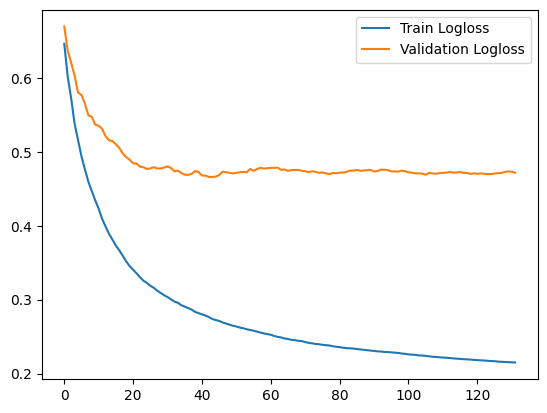

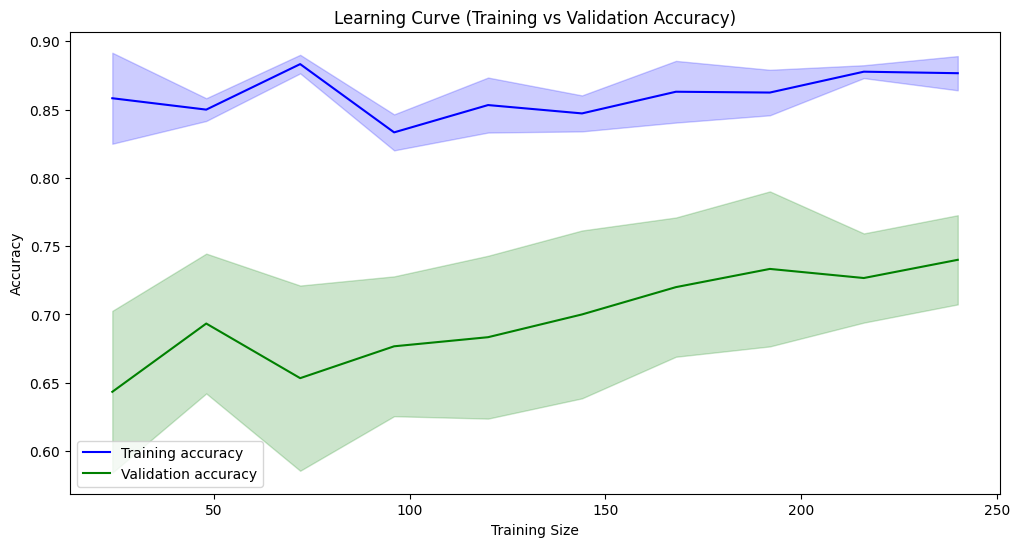

Train Accuracy: 0.8766666666666667
Test Accuracy: 0.7313432835820896


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from matplotlib import pyplot

# Get best hyperparameters from study
best_params = study.best_trial.params
#best_params = {'booster': 'dart', 'lambda': 6.109101796965115, 'alpha': 2.1542301910444617,  'learning_rate': 0.15828508410665312, 'n_estimators': 200, 'max_depth': 5,   'min_child_weight': 1, 'gamma': 0.0015829960103862651, 'subsample': 0.6335396537951385,  'colsample_bytree': 0.562796436427881, 'early_stopping_rounds': 45}

# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Fit the model with early stopping using the validation set
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=False
)

# Evaluate final model
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy on Test:", accuracy_score(y_test, y_pred_final))

# Get the evaluation results from the training process
results = final_model.evals_result()

# Print the available keys in results to help diagnose the issue
print("Available results keys:", results.keys())

# Check if 'validation_1' exists in the results
if 'validation_1' in results:
    # Plot learning curves for training and validation
    pyplot.plot(results['validation_0']['logloss'], label='Train Logloss')
    pyplot.plot(results['validation_1']['logloss'], label='Validation Logloss')
else:
    print("Validation set logloss not found in the results")

# Show the legend and plot
pyplot.legend()
pyplot.show()

# Learning Curves with Early Stopping
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10),
    fit_params={'eval_set': [(X_valid, y_valid)]}  # Still using validation set for this step
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


In [ ]:
Best_trial: {'booster': 'gbtree', 'lambda': 0.0052103621382832265, 'alpha': 0.1620577811386946, 'learning_rate': 0.1170210607506638, 'n_estimators': 327, 'max_depth': 4, 'min_child_weight': 7, 'gamma': 1.6589810670976416e-05, 'subsample': 0.7843052779851918, 'colsample_bytree': 0.5079409289423329}


In [ ]:
Best_trial: {'booster': 'dart', 'lambda': 0.020998703887689537, 'alpha': 0.1390447886551301, 'learning_rate': 0.11229332078448975, 'n_estimators': 559, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 2.0219692829063354e-05, 'subsample': 0.7175177317110472, 'colsample_bytree': 0.8899318411369608}


In [ ]:
Best_trial: {'booster': 'dart', 'lambda': 3.9815594987137994, 'alpha': 1.1692306809315036, 'learning_rate': 0.08046698602150275, 'n_estimators': 700, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 2.123245273357147e-05, 'subsample': 0.7970691270411416, 'colsample_bytree': 0.6813800155627162}

In [ ]:
Best trial: {'booster': 'dart', 'lambda': 0.09103305658827118, 'alpha': 0.22251956198876638, 'learning_rate': 0.08161540222283686, 'n_estimators': 559, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.0053773276652879475, 'subsample': 0.5030121659898422, 'colsample_bytree': 0.6694670222318585, 'early_stopping_rounds': 67}


In [ ]:
Best trial: {'booster': 'dart', 'lambda': 0.08177521234352274, 'alpha': 0.00023649167150269546, 'learning_rate': 0.1293122083586557, 'n_estimators': 576, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.00046343198602445494, 'subsample': 0.693642295185491, 'colsample_bytree': 0.7782649518684708, 'early_stopping_rounds': 61}
